## 1. Cài đặt thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datetime
import seaborn as sns
import warnings
from datetime import timedelta
warnings.filterwarnings('ignore')

## 2. Tiền xử lý xử liệu 

In [2]:
# Đọc dữ liệu từ các file chia sẵn theo tỷ lệ 60_20_20
import os
split_ratio = '70_15_15'
base_path = '/Users/nhxtrxng/Desktop/PTDLKD/IS403.P23-Gold/Dataset/Splits'

train_df = pd.read_csv(os.path.join(base_path, f'train_{split_ratio}.csv'))
val_df = pd.read_csv(os.path.join(base_path, f'val_{split_ratio}.csv'))
test_df = pd.read_csv(os.path.join(base_path, f'test_{split_ratio}.csv'))

# Gộp để chuẩn hóa + sliding window
full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Tiền xử lý
full_df['Date'] = pd.to_datetime(full_df['Date'])
for col in ['Price', 'Open', 'High', 'Low']:
    full_df[col] = full_df[col].str.replace(',', '').astype(float)
full_df['Change %'] = full_df['Change %'].str.replace('%', '').astype(float)

def parse_volume(val):
    if isinstance(val, str):
        if val.endswith('K'):
            return float(val[:-1]) * 1e3
        elif val.endswith('M'):
            return float(val[:-1]) * 1e6
        else:
            return float(val)
    return np.nan
full_df['Vol.'] = full_df['Vol.'].apply(parse_volume)

# Bổ sung: Fill giá trị trung bình cho các dòng Vol. bị thiếu (NaN)
mean_vol = full_df['Vol.'].mean()
full_df['Vol.'].fillna(mean_vol, inplace=True)

full_df = full_df.dropna().sort_values('Date').reset_index(drop=True)

## 3. Tạo dữ liệu với timestep = 90

In [3]:
features = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'CPIAUCSL']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(full_df[features])

X, y = [], []
timestep = 90
for i in range(timestep, len(scaled_data)):
    X.append(scaled_data[i - timestep:i])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

# Phân chia lại đúng với số dòng thực tế từng phần
n_train = len(train_df) - timestep
n_val = len(val_df)
n_test = len(test_df)

X_train = X[:n_train]
y_train = y[:n_train]
X_val = X[n_train:n_train + n_val]
y_val = y[n_train:n_train + n_val]
X_test = X[n_train + n_val:n_train + n_val + n_test]
y_test = y[n_train + n_val:n_train + n_val + n_test]

# Định dạng cho CNN
X_train_torch = torch.tensor(X_train.transpose(0, 2, 1), dtype=torch.float32)
X_val_torch = torch.tensor(X_val.transpose(0, 2, 1), dtype=torch.float32)
X_test_torch = torch.tensor(X_test.transpose(0, 2, 1), dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_torch = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

## 4. Tạo Dataset và Dataloader

In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TimeSeriesDataset(X_train_torch, y_train_torch)
test_ds = TimeSeriesDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

## 5. Mô hình CNN 1D

In [5]:
class CnnTimeSeries(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 256, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv1d(256, 128, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = self.dropout1(torch.relu(self.bn1(self.conv1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(x).squeeze(-1)
        return self.fc(x)

model = CnnTimeSeries(in_channels=X_train_torch.shape[1])
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 6. Train mô hình

In [6]:
epochs = 30
for epoch in range(epochs):
    model.train()
    train_losses = []
    for Xb, yb in train_loader:
        preds = model(Xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}: Train Loss = {np.mean(train_losses):.4f}")

Epoch 1: Train Loss = 0.0345
Epoch 2: Train Loss = 0.0021
Epoch 3: Train Loss = 0.0017
Epoch 4: Train Loss = 0.0018
Epoch 5: Train Loss = 0.0019
Epoch 6: Train Loss = 0.0016
Epoch 7: Train Loss = 0.0016
Epoch 8: Train Loss = 0.0014
Epoch 9: Train Loss = 0.0014
Epoch 10: Train Loss = 0.0013
Epoch 11: Train Loss = 0.0011
Epoch 12: Train Loss = 0.0014
Epoch 13: Train Loss = 0.0012
Epoch 14: Train Loss = 0.0012
Epoch 15: Train Loss = 0.0010
Epoch 16: Train Loss = 0.0010
Epoch 17: Train Loss = 0.0010
Epoch 18: Train Loss = 0.0009
Epoch 19: Train Loss = 0.0009
Epoch 20: Train Loss = 0.0010
Epoch 21: Train Loss = 0.0008
Epoch 22: Train Loss = 0.0010
Epoch 23: Train Loss = 0.0009
Epoch 24: Train Loss = 0.0007
Epoch 25: Train Loss = 0.0008
Epoch 26: Train Loss = 0.0009
Epoch 27: Train Loss = 0.0007
Epoch 28: Train Loss = 0.0007
Epoch 29: Train Loss = 0.0006
Epoch 30: Train Loss = 0.0008


## 7. Dự đoán và đánh giá

In [7]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_torch).squeeze().numpy()

y_pred_inv = scaler.inverse_transform(
    np.c_[y_pred.reshape(-1, 1), np.zeros((len(y_pred), 6))]
)[:, 0]

y_test_inv = scaler.inverse_transform(
    np.c_[y_test.reshape(-1, 1), np.zeros((len(y_test), 6))]
)[:, 0]

# Tính lại MAE, RMSE, v.v. trên dữ liệu đã inverse
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / np.clip(np.abs(y_test_inv), 1e-8, None))) * 100
r2 = r2_score(y_test_inv, y_pred_inv)
n = len(y_test_inv)
p = X_test.shape[2]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"MAE (inverse): {mae:.4f}")
print(f"MAPE (inverse): {mape:.2f}%")
print(f"RMSE (inverse): {rmse:.4f}")
print(f"R² (inverse): {r2:.4f}")
print(f"Adjusted R² (inverse): {adjusted_r2:.4f}")

MAE (inverse): 226.8871
MAPE (inverse): 10.55%
RMSE (inverse): 249.6928
R² (inverse): 0.4826
Adjusted R² (inverse): 0.4763


## 8. Hàm dự đoán 90 ngày tiếp theo

In [8]:
# Dự báo 90 ngày tiếp theo với mô hình CNN
def forecast_future_with_details(model, last_sequence, n_future, scaler):
    future_predictions = []
    current_sequence = last_sequence.copy()

    print("Dự báo 90 ngày tiếp theo:\n")
    for day in range(n_future):
        current_sequence_reshaped = torch.tensor(current_sequence.T[np.newaxis, :, :], dtype=torch.float32)
        next_pred = model(current_sequence_reshaped).detach().numpy()
        predicted_price = scaler.inverse_transform(
            np.concatenate([next_pred, np.zeros((1, 6))], axis=1)
        )[0, 0]

        input_prices = scaler.inverse_transform(
            np.concatenate([current_sequence[:, 0].reshape(-1, 1), np.zeros((90, 6))], axis=1)
        )[:, 0]

        print(f"Ngày thứ {day + 1}:")
        print(f"Input (90 ngày trước đó): {input_prices}")
        print(f"Output (giá dự đoán): {predicted_price:.2f} USD\n")

        future_predictions.append([predicted_price])
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1, 0] = next_pred[0, 0]

    return np.array(future_predictions)

## 9. Vẽ biểu đồ kết quả dự đoán

Dự báo 90 ngày tiếp theo:

Ngày thứ 1:
Input (90 ngày trước đó): [2631.  2651.7 2674.9 2712.2 2618.5 2621.3 2652.3 2669.  2646.5 2655.9
 2664.3 2636.1 2647.1 2673.3 2705.6 2741.5 2695.1 2662.4 2657.  2649.6
 2640.8 2596.  2632.5 2615.5 2622.8 2640.3 2618.4 2618.1 2641.  2669.
 2654.7 2647.4 2665.4 2672.4 2690.8 2715.  2678.6 2682.3 2717.8 2750.9
 2748.7 2785.6 2797.4 2778.3 2792.7 2752.4 2781.  2781.5 2845.2 2835.
 2857.1 2875.8 2893.  2876.7 2887.6 2934.4 2932.6 2928.7 2945.4 2900.7
 2949.  2936.1 2956.1 2953.2 2949.7 2906.  2917.8 2895.9 2848.5 2901.1
 2920.6 2926.  2926.6 2914.1 2899.4 2920.9 2946.8 2991.3 3001.1 3034.1
 3068.9 3069.1 3071.3 3048.4 3044.  3039.6 3037.3 3075.8 3114.3 3150.3]
Output (giá dự đoán): 3092.06 USD

Ngày thứ 2:
Input (90 ngày trước đó): [2651.7        2674.9        2712.2        2618.5        2621.3
 2652.3        2669.         2646.5        2655.9        2664.3
 2636.1        2647.1        2673.3        2705.6        2741.5
 2695.1        2662.4        265

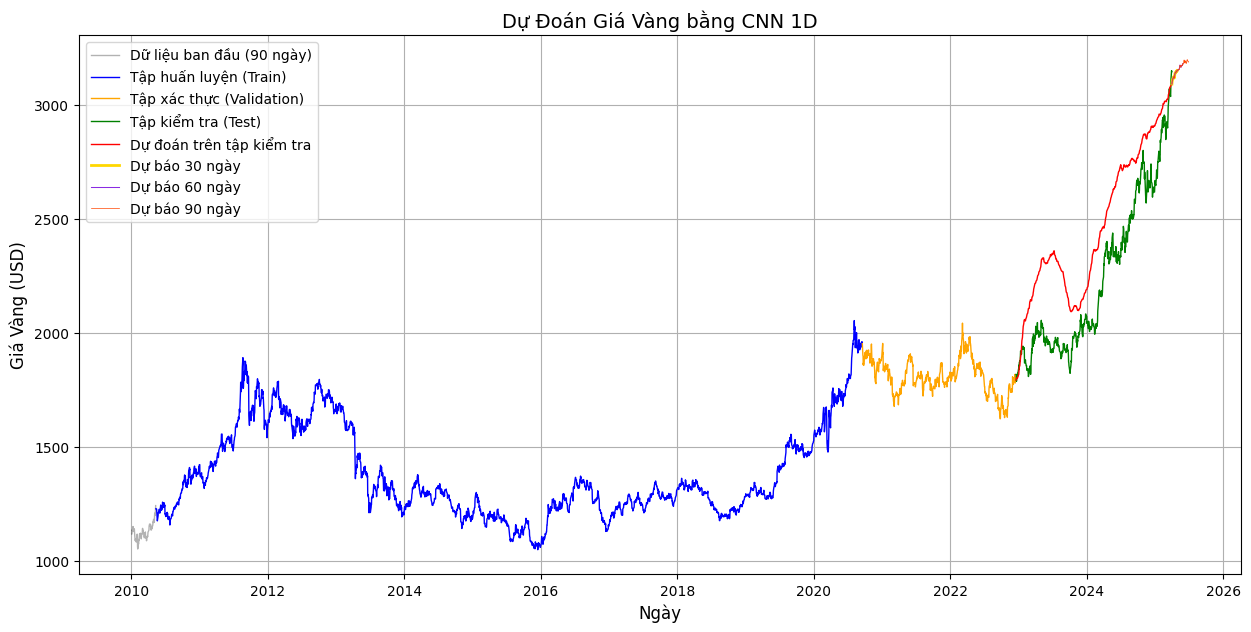

In [9]:
# Dữ liệu thời gian
full_dates = full_df['Date'].reset_index(drop=True)
train_size = len(train_df) - timestep
val_size = len(val_df)
test_size = len(test_df)

train_dates = full_dates[timestep:train_size + timestep]
val_dates = full_dates[train_size + timestep:train_size + val_size + timestep]
test_dates = full_dates[train_size + val_size + timestep:]

# Thực hiện dự đoán tương lai
last_sequence = X[-1]  # lấy sequence cuối cùng sau chuẩn hóa
future_90 = forecast_future_with_details(model, last_sequence, 90, scaler)
future_30 = future_90[:30]
future_60 = future_90[:60]

# Ngày dự báo tương lai
future_dates = pd.date_range(start=full_dates.iloc[-1] + timedelta(days=1), periods=90, freq='D')

# Giá thực tế sau inverse
scaled_prices = scaler.transform(full_df[features])[:, 0]
inv_prices = scaler.inverse_transform(np.c_[scaled_prices.reshape(-1, 1), np.zeros((len(scaled_prices), 6))])[:, 0]

train_prices = inv_prices[timestep:train_size + timestep]
val_prices = inv_prices[train_size + timestep:train_size + val_size + timestep]
test_prices = inv_prices[train_size + val_size + timestep:]

# Dự đoán test tập (y_pred đã tính trước đó)
y_pred_real = scaler.inverse_transform(np.c_[y_pred.reshape(-1, 1), np.zeros((len(y_pred), 6))])[:, 0]

# Vẽ biểu đồ
plt.figure(figsize=(15, 7))
plt.plot(full_dates[:timestep], inv_prices[:timestep], 'k-', label='Dữ liệu ban đầu (90 ngày)', alpha=0.3, linewidth=1.0)
plt.plot(train_dates, train_prices, 'b-', label='Tập huấn luyện (Train)', linewidth=1.0)
plt.plot(val_dates, val_prices, 'orange', label='Tập xác thực (Validation)', linewidth=1.0)
plt.plot(test_dates, test_prices, 'g-', label='Tập kiểm tra (Test)', linewidth=1.0)
plt.plot(test_dates, y_pred_real, 'r-', label='Dự đoán trên tập kiểm tra', linewidth=1.0)
plt.plot(future_dates[:30], future_30, color='#FFD700', label='Dự báo 30 ngày', linewidth=2.0)
plt.plot(future_dates[:60], future_60, color='#8A2BE2', label='Dự báo 60 ngày', linewidth=0.75)
plt.plot(future_dates, future_90, color='#FF4500', label='Dự báo 90 ngày', linewidth=0.5)
plt.title('Dự Đoán Giá Vàng bằng CNN 1D', fontsize=14)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá Vàng (USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()